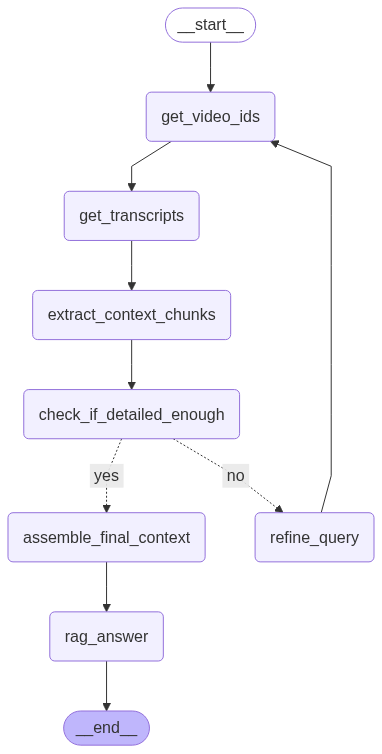

INFO:root:Running YouTube search for query: What are quantum effects in biology? Identify the effects and who has research showing and proving that these are in fact quantum mechanical effects? What is the best evidence of quantum mechanics effects taking place at the cell level?
INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0
INFO:root:Fetching transcripts for video IDs: ['B3U1NDUiwSA', 'TsNx_yHRgVI', 'yYckT0jrMt4', 'ZKGu1Y8Cxvk', 'UJHvvYN-B3g']
INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0
INFO:root:Extracting context chunks from documents
INFO:root:Checking if current context has sufficient detail
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:LLM evaluation response: Relevance: 0
Completeness: 0
Specificity: 0
Decision: no
INFO:root:Routing decision based on cached LLM output: no
INFO:root:Refining query using LLM
INFO:httpx:HTTP Request: POST 


===== FINAL ANSWER =====

The question seems to be a title or topic rather than a question. However, it appears to be asking for a discussion on the topic of quantum effects in biology, specifically in relation to coherence, tunneling, and entanglement in photosynthesis and magnetoreception, as studied by Al-Khalili, Turin, and Engel.

Quantum effects in biology is a relatively new and exciting field of research. It explores the idea that quantum phenomena, which are often thought to be restricted to the microscopic world, may play a role in biological processes.

One of the key areas of focus in this field is photosynthesis, the process by which plants convert light energy into chemical energy. Researchers like Al-Khalili, Turin, and Engel have suggested that quantum coherence, a phenomenon where particles are linked and behave as a single entity, may play a role in the efficiency of energy transfer during photosynthesis. Specifically, it's thought that excitons (bundles of energy) m

In [1]:
from typing import TypedDict, List
from langchain_core.documents import Document
from langchain_core.runnables import RunnableLambda
from langgraph.graph import StateGraph
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage
from youtube_transcript_api import YouTubeTranscriptApi
from googleapiclient.discovery import build
from IPython.display import display, Image
from langchain.tools import tool
import os
from dotenv import load_dotenv
load_dotenv()
import re
import logging
import tiktoken
import time

# --------------------
# Define Agent State
# --------------------
class State(TypedDict):
    query: str
    video_ids: List[str]
    documents: List[Document]
    context_chunks: List[str]
    answer: str
    confidence_scores: dict
    iteration: int
    max_iterations: int

# --------------------------
# Define Dynamic Tools
# --------------------------
@tool
def youtube_search_tool(query: str, max_results: int = 5) -> List[str]:
    """Search YouTube and return top video IDs."""
    YOUTUBE_API_KEY = os.environ.get("YOUTUBE_API_KEY")
    if not YOUTUBE_API_KEY:
        raise ValueError("Missing YOUTUBE_API_KEY. Please set it as an environment variable.")
    youtube = build("youtube", "v3", developerKey=YOUTUBE_API_KEY)
    search_response = youtube.search().list(
        q=query,
        type="video",
        part="id,snippet",
        maxResults=max_results
    ).execute()
    return [item["id"]["videoId"] for item in search_response["items"]]

@tool
def transcript_tool(video_id: str) -> str:
    """Fetch transcript for a given video ID."""
    try:
        transcript = YouTubeTranscriptApi.get_transcript(video_id)
        return "\n".join([t['text'] for t in transcript])
    except Exception as e:
        return f"⚠️ Error fetching transcript: {e}"

logging.basicConfig(level=logging.INFO)

# --------------------------
# Token Length Utilities
# --------------------------
def get_token_length(text: str, model: str = "gpt-4") -> int:
    enc = tiktoken.encoding_for_model(model)
    return len(enc.encode(text))

def truncate_context(chunks, model="gpt-4", max_tokens=6000):
    used_tokens = 0
    final_chunks = []
    for chunk in reversed(chunks):
        tokens = get_token_length(chunk, model)
        if used_tokens + tokens > max_tokens:
            break
        final_chunks.insert(0, chunk)
        used_tokens += tokens
    return final_chunks

# --------------------------
# Graph Node Steps
# --------------------------
def step_get_video_ids(state):
    logging.info(f"Running YouTube search for query: {state['query']}")
    ids = youtube_search_tool.invoke({"query": state['query']})
    return {**state, "video_ids": ids}

def step_get_transcripts(state):
    logging.info(f"Fetching transcripts for video IDs: {state['video_ids']}")
    docs = []
    YOUTUBE_API_KEY = os.environ.get("YOUTUBE_API_KEY")
    if not YOUTUBE_API_KEY:
        raise ValueError("Missing YOUTUBE_API_KEY. Please set it as an environment variable.")
    youtube = build("youtube", "v3", developerKey=YOUTUBE_API_KEY)
    for vid in state["video_ids"]:
        try:
            text = transcript_tool.invoke({"video_id": vid})
            video_info = youtube.videos().list(part="snippet", id=vid).execute()
            title = video_info["items"][0]["snippet"]["title"]
            url = f"https://www.youtube.com/watch?v={vid}"
            docs.append(Document(page_content=text, metadata={"video_id": vid, "title": title, "url": url}))
        except Exception as e:
            logging.warning(f"Could not fetch transcript or metadata for video ID {vid}: {e}")
    return {**state, "documents": docs}

def step_extract_context_chunks(state):
    logging.info("Extracting context chunks from documents")
    chunks = []
    for doc in state["documents"]:
        sentences = re.split(r'(?<=[.!?])\s+', doc.page_content)
        good = [s for s in sentences if len(s.split()) > 8 and any(c.isalpha() for c in s)]
        chunks.extend(good[:20])
    return {**state, "context_chunks": state.get("context_chunks", []) + chunks}

def evaluate_detail_and_update(state):
    logging.info("Checking if current context has sufficient detail")
    MODEL_NAME = os.environ.get("OPENAI_MODEL", "gpt-4")
    MAX_CONTEXT_CHUNKS = int(os.environ.get("MAX_CONTEXT_CHUNKS", 8))
    MAX_TOTAL_TOKENS = int(os.environ.get("MAX_TOTAL_TOKENS", 8000))
    llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
    context_chunks = truncate_context(state["context_chunks"], model=MODEL_NAME, max_tokens=MAX_TOTAL_TOKENS)
    context = "\n\n".join(context_chunks[-MAX_CONTEXT_CHUNKS:])
    prompt = f"""
You are an expert research assistant. Assess how well the context addresses the research question below.

Question:
{state['query']}

Context:
{context}

Evaluate the following:
1. Relevance (scale 0–10)
2. Completeness (scale 0–10)
3. Scientific Specificity (scale 0–10)
4. Final Recommendation: Answer with only \"yes\" or \"no\" — should the search stop?

Return your answer in this format:
Relevance: <score>
Completeness: <score>
Specificity: <score>
Decision: <yes/no>
"""
    try:
        response = llm.invoke([HumanMessage(content=prompt)])
    except Exception as e:
        logging.warning(f"LLM call failed: {e}")
        time.sleep(10)
        response = llm.invoke([HumanMessage(content=prompt)])
    logging.info(f"LLM evaluation response: {response.content.strip()}")
    lines = response.content.strip().split("\n")
    scores = {line.split(":")[0].strip().lower(): line.split(":")[1].strip() for line in lines if ":" in line}
    decision = scores.get("decision", "no").lower()
    state["confidence_scores"] = scores
    state["llm_decision"] = decision
    return state

def route_decision(state: dict) -> str:
    logging.info(f"Routing decision based on cached LLM output: {state.get('llm_decision', 'no')}")
    if state.get("iteration", 0) >= state.get("max_iterations", 3):
        logging.info("Max iterations reached — stopping refinement.")
        return "yes"
    return state.get("llm_decision", "no")

def step_refine_query(state):
    logging.info("Refining query using LLM")
    MODEL_NAME = os.environ.get("OPENAI_MODEL", "gpt-4")
    MAX_PREV_CONTEXT = int(os.environ.get("MAX_PREV_CONTEXT", 10))
    MAX_TOTAL_TOKENS = int(os.environ.get("MAX_TOTAL_TOKENS", 8000))
    llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
    context_chunks = truncate_context(state["context_chunks"], model=MODEL_NAME, max_tokens=MAX_TOTAL_TOKENS)
    prev_context = "\n\n".join(context_chunks[-MAX_PREV_CONTEXT:])
    prompt = f"""
You are a YouTube search optimizer. Keep the original research question mostly intact, but add specific key phrases, such as relevant researcher names (e.g., Jim Al-Khalili, Luca Turin, Greg Engel), key terms (e.g., quantum coherence, tunneling, entanglement, photosynthesis, magnetoreception), or known topics that are likely in video titles.

Be concise and targeted. Do NOT expand the query with unnecessary academic verbosity.

Original Query:
{state['query']}

Return a tightly scoped version ideal for YouTube title search:
"""
    try:
        response = llm.invoke([HumanMessage(content=prompt)])
    except Exception as e:
        logging.warning(f"LLM call failed: {e}")
        time.sleep(10)
        response = llm.invoke([HumanMessage(content=prompt)])
    return {
        **state,
        "query": response.content.strip(),
        "video_ids": [],
        "documents": [],
        "iteration": state.get("iteration", 0) + 1
    }

def step_assemble_context(state):
    logging.info("Assembling final context from top chunks")
    MAX_FINAL_CONTEXT = int(os.environ.get("MAX_FINAL_CONTEXT", 10))
    final_context = "\n\n".join(state["context_chunks"][-MAX_FINAL_CONTEXT:])
    return {**state, "final_context": final_context}

def step_rag_answer(state):
    logging.info("Generating final answer from assembled context")
    MODEL_NAME = os.environ.get("OPENAI_MODEL", "gpt-4")
    MAX_TOTAL_TOKENS = int(os.environ.get("MAX_TOTAL_TOKENS", 8000))
    llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
    context_chunks = truncate_context(state["context_chunks"], model=MODEL_NAME, max_tokens=MAX_TOTAL_TOKENS)
    final_context = "\n\n".join(context_chunks)
    prompt = f"""
Use the following context to answer the question:

Context:
{final_context}

Question:
{state['query']}

Answer in detailed, scientific language. Include a list of source video URLs at the end if applicable.
"""
    urls = [doc.metadata.get("url", "") for doc in state.get("documents", []) if doc.metadata.get("url")]
    source_refs = "\n\nSources:\n" + "\n".join(urls) if urls else ""
    try:
        response = llm.invoke([HumanMessage(content=prompt)])
    except Exception as e:
        logging.warning(f"LLM call failed: {e}")
        time.sleep(10)
        response = llm.invoke([HumanMessage(content=prompt)])
    return {**state, "answer": response.content.strip() + source_refs}

# -------------------
# Define the Graph
# -------------------
graph = StateGraph(State)
graph.add_node("get_video_ids", RunnableLambda(step_get_video_ids))
graph.add_node("get_transcripts", RunnableLambda(step_get_transcripts))
graph.add_node("extract_context_chunks", RunnableLambda(step_extract_context_chunks))
graph.add_node("check_if_detailed_enough", RunnableLambda(evaluate_detail_and_update))
graph.add_node("refine_query", RunnableLambda(step_refine_query))
graph.add_node("assemble_final_context", RunnableLambda(step_assemble_context))
graph.add_node("rag_answer", RunnableLambda(step_rag_answer))

graph.set_entry_point("get_video_ids")
graph.add_edge("get_video_ids", "get_transcripts")
graph.add_edge("get_transcripts", "extract_context_chunks")
graph.add_edge("extract_context_chunks", "check_if_detailed_enough")
graph.add_conditional_edges(
    source="check_if_detailed_enough",
    path=RunnableLambda(route_decision),
    path_map={
        "yes": "assemble_final_context",
        "no": "refine_query"
    }
)
graph.add_edge("refine_query", "get_video_ids")
graph.add_edge("assemble_final_context", "rag_answer")
graph.set_finish_point("rag_answer")

app = graph.compile()
display(Image(app.get_graph().draw_mermaid_png()))

initial_state = {
    "query": "What are quantum effects in biology? Identify the effects and who has research showing and proving that these are in fact quantum mechanical effects? What is the best evidence of quantum mechanics effects taking place at the cell level?",
    "video_ids": [],
    "documents": [],
    "context_chunks": [],
    "answer": "",
    "confidence_scores": {},
    "iteration": 0,
    "max_iterations": 3
}

final_state = app.invoke(initial_state)

print("\n===== FINAL ANSWER =====\n")
print(final_state["answer"])


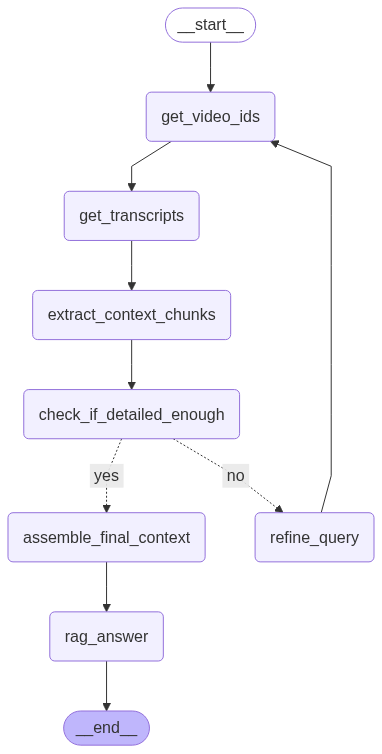

INFO:root:Running YouTube search for query: What are quantum effects in biology? Identify the effects and who has research showing and proving that these are in fact quantum mechanical effects? What is the best evidence of quantum mechanics effects taking place at the cell level?
INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0
INFO:root:Fetching transcripts for video IDs: ['B3U1NDUiwSA', 'TsNx_yHRgVI', 'yYckT0jrMt4', 'ZKGu1Y8Cxvk', 'UJHvvYN-B3g']
INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0
INFO:root:Extracting context chunks from documents
INFO:root:Checking if current context has sufficient detail
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:LLM evaluation response: Relevance: 0
Completeness: 0
Specificity: 0
Decision: no
INFO:root:Routing decision based on cached LLM output: no
INFO:root:Refining query using LLM
INFO:httpx:HTTP Request: POST 


===== FINAL ANSWER =====

The provided context does not contain any information about Nathan Babcock explaining Tryptophan's role in Quantum Biology Research or Cellular Quantum Mechanics. Therefore, it is not possible to provide an answer based on the given context.

Sources:
https://www.youtube.com/watch?v=mf6lkIipjF0


In [3]:
from typing import TypedDict, List
from langchain_core.documents import Document
from langchain_core.runnables import RunnableLambda
from langgraph.graph import StateGraph
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage
from youtube_transcript_api import YouTubeTranscriptApi
from googleapiclient.discovery import build
from IPython.display import display, Image
from langchain.tools import tool
import os
from dotenv import load_dotenv
load_dotenv()
import re
import logging
import tiktoken
import time

# --------------------
# Define Agent State
# --------------------
class State(TypedDict):
    query: str
    video_ids: List[str]
    documents: List[Document]
    context_chunks: List[str]
    answer: str
    confidence_scores: dict
    iteration: int
    max_iterations: int

# --------------------------
# Define Dynamic Tools
# --------------------------
@tool
def youtube_search_tool(query: str, max_results: int = 5) -> List[str]:
    """Search YouTube and return top video IDs."""
    YOUTUBE_API_KEY = os.environ.get("YOUTUBE_API_KEY")
    if not YOUTUBE_API_KEY:
        raise ValueError("Missing YOUTUBE_API_KEY. Please set it as an environment variable.")
    youtube = build("youtube", "v3", developerKey=YOUTUBE_API_KEY)
    search_response = youtube.search().list(
        q=query,
        type="video",
        part="id,snippet",
        maxResults=max_results
    ).execute()
    return [item["id"]["videoId"] for item in search_response["items"]]

@tool
def transcript_tool(video_id: str) -> str:
    """Fetch transcript for a given video ID."""
    try:
        transcript = YouTubeTranscriptApi.get_transcript(video_id)
        return "\n".join([t['text'] for t in transcript])
    except Exception as e:
        return f"⚠️ Error fetching transcript: {e}"

logging.basicConfig(level=logging.INFO)

# --------------------------
# Token Length Utilities
# --------------------------
def get_token_length(text: str, model: str = "gpt-4") -> int:
    enc = tiktoken.encoding_for_model(model)
    return len(enc.encode(text))

def truncate_context(chunks, model="gpt-4", max_tokens=6000):
    used_tokens = 0
    final_chunks = []
    for chunk in reversed(chunks):
        tokens = get_token_length(chunk, model)
        if used_tokens + tokens > max_tokens:
            break
        final_chunks.insert(0, chunk)
        used_tokens += tokens
    return final_chunks

# --------------------------
# Graph Node Steps
# --------------------------
def step_get_video_ids(state):
    logging.info(f"Running YouTube search for query: {state['query']}")
    ids = youtube_search_tool.invoke({"query": state['query']})
    return {**state, "video_ids": ids}

def step_get_transcripts(state):
    logging.info(f"Fetching transcripts for video IDs: {state['video_ids']}")
    docs = []
    YOUTUBE_API_KEY = os.environ.get("YOUTUBE_API_KEY")
    if not YOUTUBE_API_KEY:
        raise ValueError("Missing YOUTUBE_API_KEY. Please set it as an environment variable.")
    youtube = build("youtube", "v3", developerKey=YOUTUBE_API_KEY)
    for vid in state["video_ids"]:
        try:
            text = transcript_tool.invoke({"video_id": vid})
            video_info = youtube.videos().list(part="snippet", id=vid).execute()
            title = video_info["items"][0]["snippet"]["title"]
            url = f"https://www.youtube.com/watch?v={vid}"
            docs.append(Document(page_content=text, metadata={"video_id": vid, "title": title, "url": url}))
        except Exception as e:
            logging.warning(f"Could not fetch transcript or metadata for video ID {vid}: {e}")
    return {**state, "documents": docs}

def step_extract_context_chunks(state):
    logging.info("Extracting context chunks from documents")
    chunks = []
    for doc in state["documents"]:
        sentences = re.split(r'(?<=[.!?])\s+', doc.page_content)
        good = [s for s in sentences if len(s.split()) > 8 and any(c.isalpha() for c in s)]
        chunks.extend(good[:20])
    return {**state, "context_chunks": state.get("context_chunks", []) + chunks}

def evaluate_detail_and_update(state):
    logging.info("Checking if current context has sufficient detail")
    MODEL_NAME = os.environ.get("OPENAI_MODEL", "gpt-4")
    MAX_CONTEXT_CHUNKS = int(os.environ.get("MAX_CONTEXT_CHUNKS", 8))
    MAX_TOTAL_TOKENS = int(os.environ.get("MAX_TOTAL_TOKENS", 8000))
    llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
    context_chunks = truncate_context(state["context_chunks"], model=MODEL_NAME, max_tokens=MAX_TOTAL_TOKENS)
    context = "\n\n".join(context_chunks[-MAX_CONTEXT_CHUNKS:])
    prompt = f"""
You are an expert research assistant. Assess how well the context addresses the research question below.

Question:
{state['query']}

Context:
{context}

Evaluate the following:
1. Relevance (scale 0–10)
2. Completeness (scale 0–10)
3. Scientific Specificity (scale 0–10)
4. Final Recommendation: Answer with only \"yes\" or \"no\" — should the search stop?

Return your answer in this format:
Relevance: <score>
Completeness: <score>
Specificity: <score>
Decision: <yes/no>
"""
    try:
        response = llm.invoke([HumanMessage(content=prompt)])
    except Exception as e:
        logging.warning(f"LLM call failed: {e}")
        time.sleep(10)
        response = llm.invoke([HumanMessage(content=prompt)])
    logging.info(f"LLM evaluation response: {response.content.strip()}")
    lines = response.content.strip().split("\n")
    scores = {line.split(":")[0].strip().lower(): line.split(":")[1].strip() for line in lines if ":" in line}
    decision = scores.get("decision", "no").lower()
    state["confidence_scores"] = scores
    state["llm_decision"] = decision
    return state

def route_decision(state: dict) -> str:
    logging.info(f"Routing decision based on cached LLM output: {state.get('llm_decision', 'no')}")
    if state.get("iteration", 0) >= state.get("max_iterations", 3):
        logging.info("Max iterations reached — stopping refinement.")
        return "yes"
    return state.get("llm_decision", "no")

def step_refine_query(state):
    logging.info("Refining query using LLM")
    MODEL_NAME = os.environ.get("OPENAI_MODEL", "gpt-4")
    MAX_PREV_CONTEXT = int(os.environ.get("MAX_PREV_CONTEXT", 10))
    MAX_TOTAL_TOKENS = int(os.environ.get("MAX_TOTAL_TOKENS", 8000))
    llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
    context_chunks = truncate_context(state["context_chunks"], model=MODEL_NAME, max_tokens=MAX_TOTAL_TOKENS)
    prev_context = "\n\n".join(context_chunks[-MAX_PREV_CONTEXT:])

    FORCED_HINTS = ['Nathan Babcock', 'tryptophan']
    hint_clause = ' '.join([f'"{hint}"' for hint in FORCED_HINTS])

    prompt = f"""
You are a YouTube search optimizer. Keep the original research question mostly intact, but improve it for YouTube title-based search. You must include the terms {hint_clause} in the refined query.

Original Query:
{state['query']}

Return a refined query for YouTube title search:
"""

    try:
        response = llm.invoke([HumanMessage(content=prompt)])
    except Exception as e:
        logging.warning(f"LLM call failed: {e}")
        time.sleep(10)
        response = llm.invoke([HumanMessage(content=prompt)])

    return {
        **state,
        "query": response.content.strip(),
        "video_ids": [],
        "documents": [],
        "iteration": state.get("iteration", 0) + 1
    }

def step_assemble_context(state):
    logging.info("Assembling final context from top chunks")
    MAX_FINAL_CONTEXT = int(os.environ.get("MAX_FINAL_CONTEXT", 10))
    final_context = "\n\n".join(state["context_chunks"][-MAX_FINAL_CONTEXT:])
    return {**state, "final_context": final_context}

def step_rag_answer(state):
    logging.info("Generating final answer from assembled context")
    MODEL_NAME = os.environ.get("OPENAI_MODEL", "gpt-4")
    MAX_TOTAL_TOKENS = int(os.environ.get("MAX_TOTAL_TOKENS", 8000))
    llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
    context_chunks = truncate_context(state["context_chunks"], model=MODEL_NAME, max_tokens=MAX_TOTAL_TOKENS)
    final_context = "\n\n".join(context_chunks)
    prompt = f"""
Use the following context to answer the question:

Context:
{final_context}

Question:
{state['query']}

Answer in detailed, scientific language. Include a list of source video URLs at the end if applicable.
"""
    urls = [doc.metadata.get("url", "") for doc in state.get("documents", []) if doc.metadata.get("url")]
    source_refs = "\n\nSources:\n" + "\n".join(urls) if urls else ""
    try:
        response = llm.invoke([HumanMessage(content=prompt)])
    except Exception as e:
        logging.warning(f"LLM call failed: {e}")
        time.sleep(10)
        response = llm.invoke([HumanMessage(content=prompt)])
    return {**state, "answer": response.content.strip() + source_refs}

# -------------------
# Define the Graph
# -------------------
graph = StateGraph(State)
graph.add_node("get_video_ids", RunnableLambda(step_get_video_ids))
graph.add_node("get_transcripts", RunnableLambda(step_get_transcripts))
graph.add_node("extract_context_chunks", RunnableLambda(step_extract_context_chunks))
graph.add_node("check_if_detailed_enough", RunnableLambda(evaluate_detail_and_update))
graph.add_node("refine_query", RunnableLambda(step_refine_query))
graph.add_node("assemble_final_context", RunnableLambda(step_assemble_context))
graph.add_node("rag_answer", RunnableLambda(step_rag_answer))

graph.set_entry_point("get_video_ids")
graph.add_edge("get_video_ids", "get_transcripts")
graph.add_edge("get_transcripts", "extract_context_chunks")
graph.add_edge("extract_context_chunks", "check_if_detailed_enough")
graph.add_conditional_edges(
    source="check_if_detailed_enough",
    path=RunnableLambda(route_decision),
    path_map={
        "yes": "assemble_final_context",
        "no": "refine_query"
    }
)
graph.add_edge("refine_query", "get_video_ids")
graph.add_edge("assemble_final_context", "rag_answer")
graph.set_finish_point("rag_answer")

app = graph.compile()
display(Image(app.get_graph().draw_mermaid_png()))

initial_state = {
    "query": "What are quantum effects in biology? Identify the effects and who has research showing and proving that these are in fact quantum mechanical effects? What is the best evidence of quantum mechanics effects taking place at the cell level?",
    "video_ids": [],
    "documents": [],
    "context_chunks": [],
    "answer": "",
    "confidence_scores": {},
    "iteration": 0,
    "max_iterations": 3
}

final_state = app.invoke(initial_state)

print("\n===== FINAL ANSWER =====\n")
print(final_state["answer"])

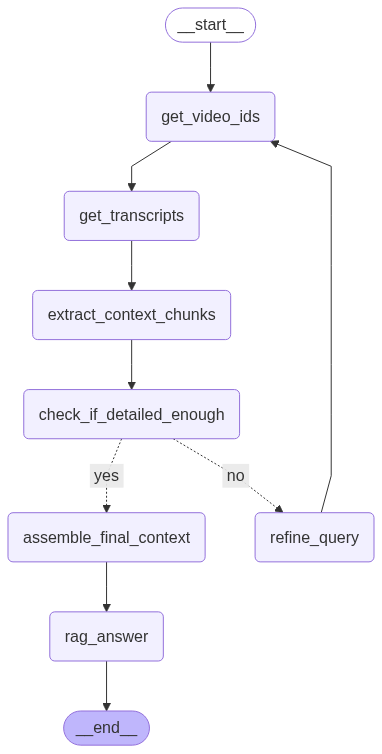

INFO:root:Running YouTube search for query: What are quantum effects in biology? Identify the effects and who has research showing and proving that these are in fact quantum mechanical effects? What is the best evidence of quantum mechanics effects taking place at the cell level?
INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0
INFO:root:Fetching transcripts for video IDs: ['B3U1NDUiwSA', 'TsNx_yHRgVI', 'yYckT0jrMt4', 'ZKGu1Y8Cxvk', 'UJHvvYN-B3g']
INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0
INFO:root:Extracting context chunks from documents
INFO:root:Checking if current context has sufficient detail
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:LLM evaluation response: Relevance: 1
Completeness: 0
Specificity: 1
Decision: no
INFO:root:Routing decision based on cached LLM output: no
INFO:root:Refining query using LLM
INFO:httpx:HTTP Request: POST 


===== FINAL ANSWER =====

The provided context does not contain any information about Nathan Babcock explaining Tryptophan's role in Quantum Biology or evidence of Quantum Mechanics in cells. Therefore, it is not possible to provide a detailed, scientific answer based on the given context.

Sources:
https://www.youtube.com/watch?v=mf6lkIipjF0


In [4]:
from typing import TypedDict, List
from langchain_core.documents import Document
from langchain_core.runnables import RunnableLambda
from langgraph.graph import StateGraph
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage
from youtube_transcript_api import YouTubeTranscriptApi
from googleapiclient.discovery import build
from IPython.display import display, Image
from langchain.tools import tool
import os
from dotenv import load_dotenv
load_dotenv()
import re
import logging
import tiktoken
import time

# --------------------
# Define Agent State
# --------------------
class State(TypedDict):
    query: str
    video_ids: List[str]
    documents: List[Document]
    context_chunks: List[str]
    answer: str
    confidence_scores: dict
    iteration: int
    max_iterations: int

# --------------------------
# Define Dynamic Tools
# --------------------------
@tool
def youtube_search_tool(query: str, max_results: int = 5) -> List[str]:
    """Search YouTube and return top video IDs."""
    YOUTUBE_API_KEY = os.environ.get("YOUTUBE_API_KEY")
    if not YOUTUBE_API_KEY:
        raise ValueError("Missing YOUTUBE_API_KEY. Please set it as an environment variable.")
    youtube = build("youtube", "v3", developerKey=YOUTUBE_API_KEY)
    search_response = youtube.search().list(
        q=query,
        type="video",
        part="id,snippet",
        maxResults=max_results
    ).execute()
    return [item["id"]["videoId"] for item in search_response["items"]]

@tool
def transcript_tool(video_id: str) -> str:
    """Fetch transcript for a given video ID."""
    try:
        transcript = YouTubeTranscriptApi.get_transcript(video_id)
        return "\n".join([t['text'] for t in transcript])
    except Exception as e:
        return f"⚠️ Error fetching transcript: {e}"

logging.basicConfig(level=logging.INFO)

# --------------------------
# Token Length Utilities
# --------------------------
def get_token_length(text: str, model: str = "gpt-4") -> int:
    enc = tiktoken.encoding_for_model(model)
    return len(enc.encode(text))

def truncate_context(chunks, model="gpt-4", max_tokens=6000):
    used_tokens = 0
    final_chunks = []
    for chunk in reversed(chunks):
        tokens = get_token_length(chunk, model)
        if used_tokens + tokens > max_tokens:
            break
        final_chunks.insert(0, chunk)
        used_tokens += tokens
    return final_chunks

# --------------------------
# Graph Node Steps
# --------------------------
def step_get_video_ids(state):
    logging.info(f"Running YouTube search for query: {state['query']}")
    ids = youtube_search_tool.invoke({"query": state['query']})
    return {**state, "video_ids": ids}

def step_get_transcripts(state):
    logging.info(f"Fetching transcripts for video IDs: {state['video_ids']}")
    docs = []
    YOUTUBE_API_KEY = os.environ.get("YOUTUBE_API_KEY")
    if not YOUTUBE_API_KEY:
        raise ValueError("Missing YOUTUBE_API_KEY. Please set it as an environment variable.")
    youtube = build("youtube", "v3", developerKey=YOUTUBE_API_KEY)
    for vid in state["video_ids"]:
        try:
            text = transcript_tool.invoke({"video_id": vid})
            video_info = youtube.videos().list(part="snippet", id=vid).execute()
            title = video_info["items"][0]["snippet"]["title"]
            url = f"https://www.youtube.com/watch?v={vid}"
            docs.append(Document(page_content=text, metadata={"video_id": vid, "title": title, "url": url}))
        except Exception as e:
            logging.warning(f"Could not fetch transcript or metadata for video ID {vid}: {e}")
    return {**state, "documents": docs}

def step_extract_context_chunks(state):
    logging.info("Extracting context chunks from documents")
    chunks = []
    for doc in state["documents"]:
        sentences = re.split(r'(?<=[.!?])\s+', doc.page_content)
        good = [s for s in sentences if len(s.split()) > 8 and any(c.isalpha() for c in s)]
        chunks.extend(good[:20])
    return {**state, "context_chunks": state.get("context_chunks", []) + chunks}

def evaluate_detail_and_update(state):
    logging.info("Checking if current context has sufficient detail")
    MODEL_NAME = os.environ.get("OPENAI_MODEL", "gpt-4")
    MAX_CONTEXT_CHUNKS = int(os.environ.get("MAX_CONTEXT_CHUNKS", 8))
    MAX_TOTAL_TOKENS = int(os.environ.get("MAX_TOTAL_TOKENS", 8000))
    llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
    context_chunks = truncate_context(state["context_chunks"], model=MODEL_NAME, max_tokens=MAX_TOTAL_TOKENS)
    context = "\n\n".join(context_chunks[-MAX_CONTEXT_CHUNKS:])
    prompt = f"""
You are an expert research assistant. Assess how well the context addresses the research question below.

Question:
{state['query']}

Context:
{context}

Evaluate the following:
1. Relevance (scale 0–10)
2. Completeness (scale 0–10)
3. Scientific Specificity (scale 0–10)
4. Final Recommendation: Answer with only \"yes\" or \"no\" — should the search stop?

Return your answer in this format:
Relevance: <score>
Completeness: <score>
Specificity: <score>
Decision: <yes/no>
"""
    try:
        response = llm.invoke([HumanMessage(content=prompt)])
    except Exception as e:
        logging.warning(f"LLM call failed: {e}")
        time.sleep(10)
        response = llm.invoke([HumanMessage(content=prompt)])
    logging.info(f"LLM evaluation response: {response.content.strip()}")
    lines = response.content.strip().split("\n")
    scores = {line.split(":")[0].strip().lower(): line.split(":")[1].strip() for line in lines if ":" in line}
    decision = scores.get("decision", "no").lower()
    state["confidence_scores"] = scores
    state["llm_decision"] = decision
    return state

def route_decision(state: dict) -> str:
    logging.info(f"Routing decision based on cached LLM output: {state.get('llm_decision', 'no')}")
    if state.get("iteration", 0) >= state.get("max_iterations", 3):
        logging.info("Max iterations reached — stopping refinement.")
        return "yes"
    return state.get("llm_decision", "no")

def step_refine_query(state):
    logging.info("Refining query using LLM")
    MODEL_NAME = os.environ.get("OPENAI_MODEL", "gpt-4")
    MAX_PREV_CONTEXT = int(os.environ.get("MAX_PREV_CONTEXT", 10))
    MAX_TOTAL_TOKENS = int(os.environ.get("MAX_TOTAL_TOKENS", 8000))
    llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
    context_chunks = truncate_context(state["context_chunks"], model=MODEL_NAME, max_tokens=MAX_TOTAL_TOKENS)

    # DEBUG: Log the content of context chunks to verify transcript contents
    for i, chunk in enumerate(context_chunks):
        logging.debug(f"Context Chunk {i} (first 300 chars): {chunk[:300]}")

    prev_context = "\n\n".join(context_chunks[-MAX_PREV_CONTEXT:])

    FORCED_HINTS = ['Nathan Babcock', 'tryptophan']
    hint_clause = ' '.join([f'"{hint}"' for hint in FORCED_HINTS])

    prompt = f"""
You are a YouTube search optimizer. Keep the original research question mostly intact, but improve it for YouTube title-based search. You must include the terms {hint_clause} in the refined query.

Original Query:
{state['query']}

Return a refined query for YouTube title search:
"""

    try:
        response = llm.invoke([HumanMessage(content=prompt)])
    except Exception as e:
        logging.warning(f"LLM call failed: {e}")
        time.sleep(10)
        response = llm.invoke([HumanMessage(content=prompt)])

    return {
        **state,
        "query": response.content.strip(),
        "video_ids": [],
        "documents": [],
        "iteration": state.get("iteration", 0) + 1
    }

def step_assemble_context(state):
    logging.info("Assembling final context from top chunks")
    MAX_FINAL_CONTEXT = int(os.environ.get("MAX_FINAL_CONTEXT", 10))
    final_context = "\n\n".join(state["context_chunks"][-MAX_FINAL_CONTEXT:])
    return {**state, "final_context": final_context}

def step_rag_answer(state):
    logging.info("Generating final answer from assembled context")
    MODEL_NAME = os.environ.get("OPENAI_MODEL", "gpt-4")
    MAX_TOTAL_TOKENS = int(os.environ.get("MAX_TOTAL_TOKENS", 8000))
    llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
    context_chunks = truncate_context(state["context_chunks"], model=MODEL_NAME, max_tokens=MAX_TOTAL_TOKENS)
    final_context = "\n\n".join(context_chunks)
    prompt = f"""
Use the following context to answer the question:

Context:
{final_context}

Question:
{state['query']}

Answer in detailed, scientific language. Include a list of source video URLs at the end if applicable.
"""
    urls = [doc.metadata.get("url", "") for doc in state.get("documents", []) if doc.metadata.get("url")]
    source_refs = "\n\nSources:\n" + "\n".join(urls) if urls else ""
    try:
        response = llm.invoke([HumanMessage(content=prompt)])
    except Exception as e:
        logging.warning(f"LLM call failed: {e}")
        time.sleep(10)
        response = llm.invoke([HumanMessage(content=prompt)])
    return {**state, "answer": response.content.strip() + source_refs}

# -------------------
# Define the Graph
# -------------------
graph = StateGraph(State)
graph.add_node("get_video_ids", RunnableLambda(step_get_video_ids))
graph.add_node("get_transcripts", RunnableLambda(step_get_transcripts))
graph.add_node("extract_context_chunks", RunnableLambda(step_extract_context_chunks))
graph.add_node("check_if_detailed_enough", RunnableLambda(evaluate_detail_and_update))
graph.add_node("refine_query", RunnableLambda(step_refine_query))
graph.add_node("assemble_final_context", RunnableLambda(step_assemble_context))
graph.add_node("rag_answer", RunnableLambda(step_rag_answer))

graph.set_entry_point("get_video_ids")
graph.add_edge("get_video_ids", "get_transcripts")
graph.add_edge("get_transcripts", "extract_context_chunks")
graph.add_edge("extract_context_chunks", "check_if_detailed_enough")
graph.add_conditional_edges(
    source="check_if_detailed_enough",
    path=RunnableLambda(route_decision),
    path_map={
        "yes": "assemble_final_context",
        "no": "refine_query"
    }
)
graph.add_edge("refine_query", "get_video_ids")
graph.add_edge("assemble_final_context", "rag_answer")
graph.set_finish_point("rag_answer")

app = graph.compile()
display(Image(app.get_graph().draw_mermaid_png()))

initial_state = {
    "query": "What are quantum effects in biology? Identify the effects and who has research showing and proving that these are in fact quantum mechanical effects? What is the best evidence of quantum mechanics effects taking place at the cell level?",
    "video_ids": [],
    "documents": [],
    "context_chunks": [],
    "answer": "",
    "confidence_scores": {},
    "iteration": 0,
    "max_iterations": 3
}

final_state = app.invoke(initial_state)

print("\n===== FINAL ANSWER =====\n")
print(final_state["answer"])